In [1]:
import pandas as pd
import category_encoders as ce
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes


# Sobre clusterização

1) https://medium.com/turing-talks/clustering-conceitos-básicos-principais-algoritmos-e-aplicação-ace572a062a9

2) https://blog.somostera.com/data-science/clusterização-de-dados

3) https://www.sciencedirect.com/science/article/pii/S0167865509002323

# Pré-processamento

Pré-processamento. Pode envolver:

1) Remoção de outliers: outliers são observações que se desviam significativamente das outras observações no conjunto de dados (seja por ser um valor muito maior ou menor que os demais) e podem distorcer os resultados da clusterização, puxando o centro de um cluster em sua direção ou criando clusters adicionais desnecessários;

2) Normalização de variáveis: a normalização (ou padronização) das variáveis é essencial, especialmente quando as variáveis estão em diferentes escalas ou unidades;

3) Codificação de categorias: para métodos de clusterização que operam em espaço métrico/númerico, como o K-Means, é necessário converter variáveis categóricas em formatos numéricos através de técnicas como codificação One-Hot ou Binary Encoding;

4) Tratamento de valores nulos: valores nulos podem distorcer a análise de clusterização se não forem adequadamente tratados. Estratégias comuns para lidar com valores nulos incluem imputação, onde valores nulos são substituídos por um valor estimado com base em outras observações (média, mediana ou um valor predito por um modelo), e exclusão, onde linhas ou colunas com valores nulos são removidas;

5) Redução de Dimensionalidade: em conjuntos de dados com alta dimensionalidade (muitas colunas), técnicas de redução de dimensionalidade, como PCA (Análise de Componentes Principais) ou t-SNE, podem ser aplicadas para simplificar os dados sem perder informações essenciais. Isso pode melhorar a eficiência computacional e a qualidade dos clusters, facilitando a identificação de estruturas nos dados;


In [2]:
# Leitura do arquivo
nomeDoArquivo = "2014 a 2018-1"
data = pd.read_excel(nomeDoArquivo + ".xlsx")
backup = data.copy()

# Print dos nomes das colunas
data.columns

Index(['Data de cadastro', 'UF', 'Munícipio', 'Violação', 'Residência',
       'Filhos violência', 'Relação vítima-suspeito',
       'Comportamento efeito agressor', 'Tipo de violência',
       'Violência familiar', 'Denunciante', 'Frequência',
       'Drogas Álcool Suspeito', 'Filhos vítima',
       'Dependência Financeira da Vítima', 'Tempo de violência contexto',
       'Coabitação contexto', 'Risco contexto', 'Sexo da vítima',
       'Sexo do suspeito', 'Raça\Cor da vítima', 'Raça\Cor do suspeito',
       'Faixa etária da vítima', 'Faixa etária do suspeito',
       'Grau de instrução da vítima', 'Grau de instrução do suspeito'],
      dtype='object')

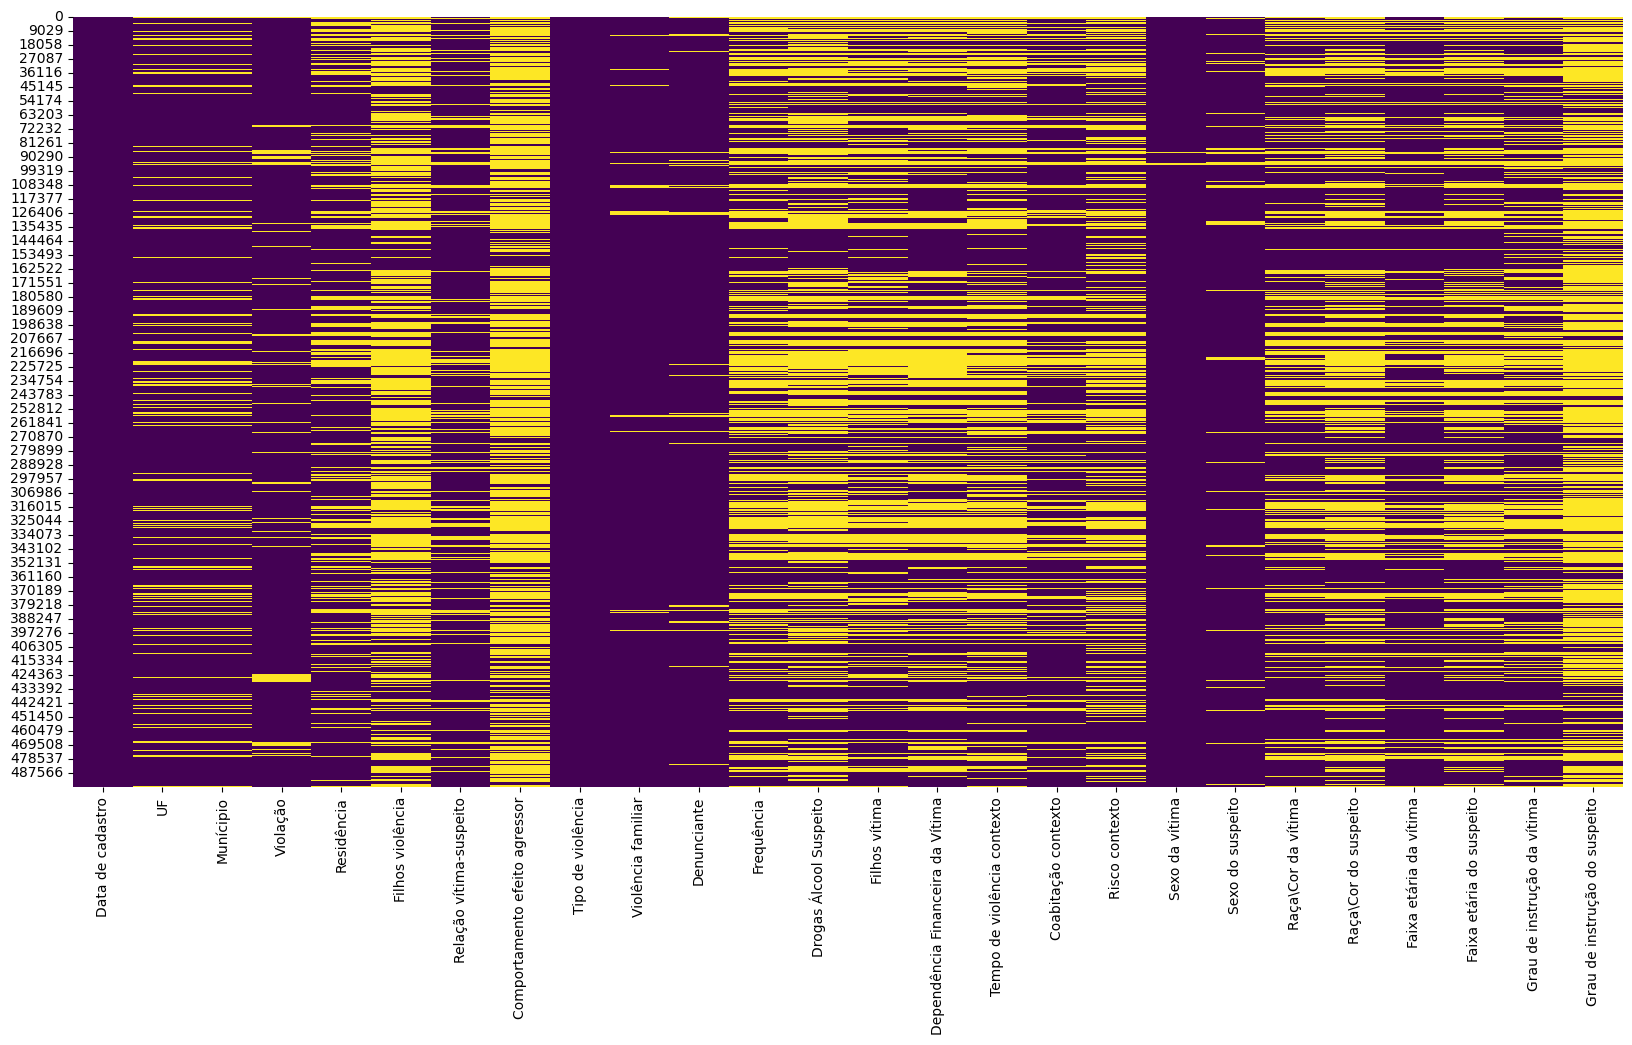

In [3]:
# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.show()

In [9]:
numeroDeLinhasComNulo = data.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = data.notnull().all(axis=1).sum()
totalDeLinhas = len(data)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")


Linhas sem valores nulos: 50370/496590 (10.14%)


In [11]:
def FiltraTabela(df, nullValuesPercentAcceptable, uniqueValuesCountAcceptable): 
    # Define um novo dataset com as colunas que possuem um número de valores nulos e occorrências únicas aceitáveis para a codificação,
    # diminuido assim a dimensionalidade
    selectedColumns = []

    # Padronização de valores ausentes. Define os valores em ausentes como "NULO"
    df = df.applymap(lambda x: "NULO" if pd.isnull(x) else x)

    # Para cada coluna do dataset
    for column in df:
        # Cálculo da porcentagem de valores nulos
        nullValuesPercent = (df[column].value_counts().get('NULO', 0) * 100) / len(df)

        # Cálculo do número de ocorrências únicas
        uniqueValuesCount = df[column].nunique()

        # Prints para verificação
        print(f'Coluna: {column}')
        print(f'Porcentagem de Valores Nulos: {nullValuesPercent:.2f}%')
        print(f'Número de Valores Únicos: {uniqueValuesCount}')

        # Condição para compôr o novo dataset
        if nullValuesPercent < nullValuesPercentAcceptable and uniqueValuesCount < uniqueValuesCountAcceptable:
            selectedColumns.append(column)
            print("Inserido\n")
        else:
            print("Não Inserido\n")

    # Cria uma cópia com as colunas definidas anteriormente.
    dfFiltered = df[selectedColumns].copy()

    # Define todas as colunas do dataset como string
    dfFiltered = dfFiltered.astype(str)

    return dfFiltered

def RemoveLinhasComNulos(df):
    # Remove as linhas com valores nulos
    df.dropna(inplace=True)

    # Define todas as colunas do dataset como string
    df = df.astype(str)

    return df



# Escolha do Número de Clusters e Algoritmos de Inicialização 

A determinação do número adequado de clusters é fundamental para a preparação de modelos, principalmente para aqueles que utilizam métodos de clusterização que exigem a definição de uma quantidade préviamente, como o K-Modes e K-Means. 

O número de clusters pode, em alguns casos, ser facilmente determinado a partir do contexto de onde foram tirados os dados. Para dados de vendas de uma loja, por exemplo, o número de clusters pode ser referente ao número de produtos que a loja vende, de maneira que cada cluster representa o perfil do cliente que o consome. 

Se não, métodos como o Elbow Method, o Silhouette Score ou o Davies-Bouldin Index podem ajudar a estimar um número ótimo de clusters baseando-se na coesão interna dos clusters e na separação entre eles.

Aqui será usado o Elbow Method para encontrar um K (número de clusters) ótimo para nosso data set, com diferentes algoritmos de escolha para os valores iniciais de referência (modes) de cada cluster.

Todas as execuções serão feitas 5 vezes (n_init = 5) para garantir que não hajam tendências na geração de números aleatórios.

# Clusterização com K-Modes

1) https://pypi.org/project/kmodes/ 

2) https://harikabonthu96.medium.com/kmodes-clustering-2286a9bfdcfb

3) https://awari.com.br/aprenda-a-utilizar-o-k-modes-com-python-para-analise-de-dados/?utm_source=blog&utm_campaign=projeto+blog&utm_medium=Aprenda%20a%20Utilizar%20o%20K-Modes%20com%20Python%20para%20Análise%20de%20Dados

4) https://link.springer.com/article/10.1007/s00357-001-0004-3

In [12]:
dataFiltered = RemoveLinhasComNulos(data)
# dataFiltered = FiltraTabela(data, 5, 10)

# Definição de com quantos clusters será testado.
numbersOfClustersKModes = range(1,10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Modes
costRandom = []
costCao = []
costHuang = []

In [13]:
# Escolha aleatória dos modes (init = "random").
for clustersNumber in list(numbersOfClustersKModes):
    kmode = KModes(n_clusters=clustersNumber, init = "random", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataFiltered)
    costRandom.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 2
Best run was number 2
Best run was number 5
Best run was number 5
Best run was number 5
Best run was number 2
Best run was number 5


In [14]:
# Modes escolhidos com base no algoritmo de Cao (init = "cao").
for clustersNumber in list(numbersOfClustersKModes):
    kmode = KModes(n_clusters=clustersNumber, init = "cao", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataFiltered)
    costCao.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1


In [15]:
# Modes escolhidos com base no algoritmo de Huang (init = "huang").
for clustersNumber in list(numbersOfClustersKModes):
    kmode = KModes(n_clusters=clustersNumber, init = "huang", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataFiltered)
    costHuang.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 4
Best run was number 5
Best run was number 3
Best run was number 4
Best run was number 5
Best run was number 5
Best run was number 5


In [16]:
costsKModes = pd.DataFrame({
    "Random" : costRandom,
    "Cao" : costCao,
    "Huang" : costHuang,
    "Número de Clusters" : numbersOfClustersKModes
})

# Visualização dos custos
#fig = px.line(
#    costsKModes, 
#    x = "Número de Clusters", 
#    y = ["Random", "Cao", "Huang"], 
#    title = (
#        f"Método do Cotovelo para o KModes com até {len(numbersOfClustersKModes)} clusters<br>"
#        f"(dataset: {nomeDoArquivo}, "
#        f"porcentagem de valores nulos aceito: {nullValuesPercentAcceptable}%, "
#        f"quantia de valores únicos por coluna aceito: {uniqueValuesCountAcceptable})"
#    )
#)

# Visualização dos custos
fig = px.line(
    costsKModes, 
    x = "Número de Clusters", 
    y = ["Random", "Cao", "Huang"], 
    title = (
        f"Método do Cotovelo para o KModes com até {len(numbersOfClustersKModes)} clusters<br>"
        f"(dataset: {nomeDoArquivo}, removidas todas as linhas com valores nulos)"
    )
)

fig.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Custo",
    legend_title="Método de Inicialização"
)

fig.show()

# Clusterização com K-Means

## Teste 1 

Teste para verificar se o tipo de condificação (Binária e One-Hot) influencia no resultado da clusterização.

**Conclusão**: Não influencia.



### Teste 1.1: 

**Codificação**: binária

**Porcentagem de valores únicos aceito**: -
         
**Número de occorrências únicas aceita**: - 

In [17]:
# Cria o dataset com a Codificação Binária
codificador = ce.BinaryEncoder(cols=data.columns)
dataBinaryTest1_1 = codificador.fit_transform(data)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest1_1 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest1_1 = []
inertiaKMeansTest1_1 = []

c:\Users\gabri\miniconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

c:\Users\gabri\miniconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

c:\Users\gabri\miniconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.

In [18]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest1_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataBinaryTest1_1)
    inertiaRandomTest1_1.append(kmeans_random.inertia_)

In [19]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest1_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataBinaryTest1_1)
    inertiaKMeansTest1_1.append(kmeans_kmeans.inertia_)

In [20]:
inertiasKMeansTest1_1 = pd.DataFrame({
    "Random" : inertiaRandomTest1_1,
    "K-Means++" : inertiaKMeansTest1_1,
    "Número de Clusters" : numbersOfClustersKMeansTest1_1
})

# Visualização dos custos
fig = px.line(
    inertiasKMeansTest1_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 1.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest1_1)} clusters<br> "
        f"(dataset: {nomeDoArquivo}, codificação: binária, "
        f"porcentagem de valores nulos aceito: 100%, "
        f"quantia de valores únicos por coluna aceito: tudo)"
    )
)

fig.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

fig.show()

### Teste 1.2: 

**Codificação**: binária

**Porcentagem de valores únicos aceito**: 50%
         
**Número de occorrências únicas aceita**: 500 

In [29]:
# Cria o dataset filtrado e aplica a Codificação Binária
nullValuesPercentAcceptableTest1_2 = 50
uniqueValuesCountAcceptableTest1_2 = 500
#dataFilteredTest1_2 = FiltraTabela(data, nullValuesPercentAcceptableTest1_2, uniqueValuesCountAcceptableTest1_2)
dataFilteredTest1_2 = RemoveLinhasComNulos(data)
codificador = ce.BinaryEncoder(cols=dataFilteredTest1_2.columns)
dataFilteredBinaryTest1_2 = codificador.fit_transform(dataFilteredTest1_2)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest1_2 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest1_2 = []
inertiaKMeansTest1_2 = []

In [30]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest1_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataFilteredBinaryTest1_2)
    inertiaRandomTest1_2.append(kmeans_random.inertia_)

In [31]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest1_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataFilteredBinaryTest1_2)
    inertiaKMeansTest1_2.append(kmeans_kmeans.inertia_)

In [32]:
inertiasKMeansTest1_2 = pd.DataFrame({
    "Random" : inertiaRandomTest1_2,
    "K-Means++" : inertiaKMeansTest1_2,
    "Número de Clusters" : numbersOfClustersKMeansTest1_2
})

# Visualização dos custos
#fig = px.line(
#    inertiasKMeansTest1_2, 
#    x = "Número de Clusters", 
#    y = ["Random", "K-Means++"], 
#    title = (
#        f"Teste 1.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest1_2)} clusters<br> "
#        f"(dataset: {nomeDoArquivo}, codificação: binária, "
#        f"porcentagem de valores nulos aceito: {nullValuesPercentAcceptableTest1_2}%, "
#        f"quantia de valores únicos por coluna aceito: {uniqueValuesCountAcceptableTest1_2})"
#    )
#)

# Visualização dos custos
fig = px.line(
    inertiasKMeansTest1_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 1.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest1_2)} clusters<br> "
        f"(dataset: {nomeDoArquivo}, codificação: binária, sem valores nulos)"
    )
)

fig.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

fig.show()

### Teste 1.3: 

**Codificação**: One-Hot

**Porcentagem de valores únicos aceito**: 50%
         
**Número de occorrências únicas aceita**: 500 

In [35]:
# Cria o dataset filtrado e aplica Codificação One-Hot
nullValuesPercentAcceptableTest1_3 = 100
uniqueValuesCountAcceptableTest1_3 = 500
dataFilteredTest1_3Part1 = FiltraTabela(data, nullValuesPercentAcceptableTest1_3, uniqueValuesCountAcceptableTest1_3)
dataFilteredTest1_3 = RemoveLinhasComNulos(dataFilteredTest1_3Part1)
dataFilteredOneHotTest1_3 = pd.get_dummies(dataFilteredTest1_3)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest1_3 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest1_3 = []
inertiaKMeansTest1_3 = []

C:\Users\gabri\AppData\Local\Temp\ipykernel_9004\1044222144.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Coluna: Data de cadastro
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 1729
Não Inserido

Coluna: UF
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 27
Inserido

Coluna: Munícipio
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 3995
Não Inserido

Coluna: Violação
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 24086
Não Inserido

Coluna: Residência
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 2
Inserido

Coluna: Filhos violência
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 3
Inserido

Coluna: Relação vítima-suspeito
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 39
Inserido

Coluna: Comportamento efeito agressor
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 5
Inserido

Coluna: Tipo de violência
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 8
Inserido

Coluna: Violência familiar
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 2
Inserido

In [36]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest1_3:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataFilteredOneHotTest1_3)
    inertiaRandomTest1_3.append(kmeans_random.inertia_)

In [37]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest1_3:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataFilteredOneHotTest1_3)
    inertiaKMeansTest1_3.append(kmeans_kmeans.inertia_)

In [39]:
inertiasKMeansTest1_3 = pd.DataFrame({
    "Random" : inertiaRandomTest1_3,
    "K-Means++" : inertiaKMeansTest1_3,
    "Número de Clusters" : numbersOfClustersKMeansTest1_3
})

# Visualização dos custos
#fig = px.line(
#    inertiasKMeansTest1_3, 
#    x = "Número de Clusters", 
#    y = ["Random", "K-Means++"], 
#    title = (
#        f"Teste 1.3: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest1_3)} clusters<br> "
#        f"(dataset: {nomeDoArquivo}, codificação: One-Hot, "
#        f"porcentagem de valores nulos aceito: {nullValuesPercentAcceptableTest1_3}%, "
#        f"quantia de valores únicos por coluna aceito: {uniqueValuesCountAcceptableTest1_3})"
#    )
#)

# Visualização dos custos
fig = px.line(
    inertiasKMeansTest1_3, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 1.3: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest1_3)} clusters<br> "
        f"(dataset: {nomeDoArquivo}, codificação: One-Hot, removidas linhas com nulos,"
        f"porcentagem de valores nulos aceito: {nullValuesPercentAcceptableTest1_3}%, "
        f"quantia de valores únicos por coluna aceito: {uniqueValuesCountAcceptableTest1_3})"
    )
)

fig.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

fig.show()

## Teste 2

Teste de clusterização sobre colunas especificas de perfil de vítima e suspeito, para as duas codificações. Colunas usadas:

 'Sexo da vítima',
 'Sexo do suspeito', 
 'Raça\Cor da vítima', 
 'Raça\Cor do suspeito',
 'Faixa etária da vítima', 
 'Faixa etária do suspeito',
 'Grau de instrução da vítima', 
 'Grau de instrução do suspeito'

### Teste 2.1

**Codificação**: Binária

In [40]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest2_1 = data[['Sexo da vítima',
                            'Sexo do suspeito',
                            'Raça\\Cor da vítima',
                            'Raça\\Cor do suspeito',
                            'Faixa etária da vítima',
                            'Faixa etária do suspeito',
                            'Grau de instrução da vítima',
                            'Grau de instrução do suspeito']].copy()

# Remove as linhas com valores nulos
dataSelectedTest2_1 = RemoveLinhasComNulos(dataSelectedTest2_1)

# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedTest2_1.columns)
dataSelectedBinaryTest2_1 = codificador.fit_transform(dataSelectedTest2_1) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest2_1 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest2_1 = []
inertiaKMeansTest2_1 = []

In [41]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest2_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedBinaryTest2_1)
    inertiaRandomTest2_1.append(kmeans_random.inertia_)

In [42]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest2_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedBinaryTest2_1)
    inertiaKMeansTest2_1.append(kmeans_kmeans.inertia_)

In [43]:
inertiasKMeansTest2_1 = pd.DataFrame({
    "Random" : inertiaRandomTest2_1,
    "K-Means++" : inertiaKMeansTest2_1,
    "Número de Clusters" : numbersOfClustersKMeansTest2_1
})

# Visualização dos custos
#fig = px.line(
#    inertiasKMeansTest2_1, 
#    x = "Número de Clusters", 
#    y = ["Random", "K-Means++"], 
#    title = (
#        f"Teste 2.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_1)} clusters<br> "
#        f"(dataset: {nomeDoArquivo}, codificação: binária, colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução)"
#    )
#)

# Visualização dos custos
fig = px.line(
    inertiasKMeansTest2_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 2.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_1)} clusters<br> "
        f"(dataset: {nomeDoArquivo}, codificação: binária, linhas com nulo removidas, colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução)"
    )
)

fig.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

fig.show()

### Teste 2.2

**Codificação**: One-Hot

In [44]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest2_2 = data[['Sexo da vítima',
                     'Sexo do suspeito',
                     'Raça\\Cor da vítima',
                     'Raça\\Cor do suspeito',
                     'Faixa etária da vítima',
                     'Faixa etária do suspeito',
                     'Grau de instrução da vítima',
                     'Grau de instrução do suspeito']].copy()

# Remove as linhas com valores nulos
dataSelectedTest2_2Part1 = FiltraTabela(data, 100, 500)
dataSelectedTest2_2 = RemoveLinhasComNulos(dataSelectedTest2_2Part1)

# Aplica a codificação One-Hot
dataSelectedOneHotTest2_2 = pd.get_dummies(dataSelectedTest2_2)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest2_2 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest2_2 = []
inertiaKMeansTest2_2 = []

C:\Users\gabri\AppData\Local\Temp\ipykernel_9004\1044222144.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Coluna: Data de cadastro
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 1729
Não Inserido

Coluna: UF
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 27
Inserido

Coluna: Munícipio
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 3995
Não Inserido

Coluna: Violação
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 24086
Não Inserido

Coluna: Residência
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 2
Inserido

Coluna: Filhos violência
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 3
Inserido

Coluna: Relação vítima-suspeito
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 39
Inserido

Coluna: Comportamento efeito agressor
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 5
Inserido

Coluna: Tipo de violência
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 8
Inserido

Coluna: Violência familiar
Porcentagem de Valores Nulos: 0.00%
Número de Valores Únicos: 2
Inserido

In [45]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest2_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedOneHotTest2_2)
    inertiaRandomTest2_2.append(kmeans_random.inertia_)

In [46]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest2_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedOneHotTest2_2)
    inertiaKMeansTest2_2.append(kmeans_kmeans.inertia_)

In [48]:
inertiasKMeansTest2_2 = pd.DataFrame({
    "Random" : inertiaRandomTest2_2,
    "K-Means++" : inertiaKMeansTest2_2,
    "Número de Clusters" : numbersOfClustersKMeansTest2_2
})

# Visualização dos custos
#fig = px.line(
#    inertiasKMeansTest2_2, 
#    x = "Número de Clusters", 
#    y = ["Random", "K-Means++"], 
#    title = (
#        f"Teste 2.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_2)} clusters<br> "
#        f"(dataset: {nomeDoArquivo}, codificação: One-Hot, colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução)"
#    )
#)

# Visualização dos custos
fig = px.line(
    inertiasKMeansTest2_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 2.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_2)} clusters<br> "
        f"(dataset: {nomeDoArquivo}, codificação: One-Hot, linhas com nulo removidas, colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução)"
    )
)

fig.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

fig.show()